# MLBacktester

In this Trading Strategies the direction of market is predicted with Machine Learning. I will use logistic regression module of scikit-learn

In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [75]:
class MLBacktester:
    
    def __init__(self, symbol, start, end, tc ):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.model = LogisticRegression(C = 1e6, max_iter = 100000, multi_class = "ovr")
        self.results = None
        self.get_data()
        
        
    def __repr__ (self):
        rep = "MLBacktester(symbol = {}, start = {}, end = {}, tc = {})"
        return rep.format(self.symbol, self.start, self.end, self.tc)
    
    def get_data(self):
        raw = pd.read_csv("five_minute_pairs.csv", parse_dates=["time"], index_col=["time"])
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol:"price"}, inplace = True)
        raw["returns"] = np.log(raw/ raw.shift(1))
        self.data = raw
    
    def split_data(self, start, end):
        data = self.data.loc[start:end].copy()
        return data
    
    def prepare_features(self, start, end):
        self.data_subset = self.split_data(start, end)
        self.feature_columns = []
        
        for lag in range(1, self.lags + 1):
            col = "lag{}".format(lag)
            self.data_subset[col] = self.data_subset["returns"].shift(lag)
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)
    
    def model_fit(self, start, end):
        self.prepare_features(start, end)
        self.model.fit(self.data_subset[self.feature_columns], np.sign(self.data_subset["returns"]))
        
    def test_strategy(self, train_ratio=0.7, lags = 5):
        self.lags = lags

        full_data = self.data.copy().dropna()
        split_index = int(len(full_data)*train_ratio)
        split_date = full_data.index[split_index - 1]
        train_start = full_data.index[0]
        test_end = full_data.index[-1]
        
        self.model_fit(train_start, split_date)
        
        self.prepare_features(split_date, test_end)
        
        predict = self.model.predict(self.data_subset[self.feature_columns])
        self.data_subset["pred"] = predict
        
        self.data_subset["strategy"] = self.data_subset["pred"] * self.data_subset["returns"]
        
        self.data_subset["trades"] = self.data_subset["pred"].diff().fillna(0).abs()
        
        self.data_subset.strategy = self.data_subset.strategy - self.data_subset.trades * self.tc
        
        self.data_subset["creturns"] = self.data_subset["returns"].cumsum().apply(np.exp)
        self.data_subset["cstrategy"] = self.data_subset['strategy'].cumsum().apply(np.exp)
        self.results = self.data_subset
        
        perf = self.results["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - self.results["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):

        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "Logistic Regression: {} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))

In [76]:
symbol = "EURUSD"
ptc = 0.00007

In [77]:
ml = MLBacktester(symbol, "2019-01-01", "2020-08-31", ptc)

In [78]:
ml

MLBacktester(symbol = EURUSD, start = 2019-01-01, end = 2020-08-31, tc = 7e-05)

In [79]:
ml.data

price   returns
time                                         
2019-01-01 22:00:00+00:00  1.146580       NaN
2019-01-01 22:05:00+00:00  1.146350 -0.000201
2019-01-01 22:10:00+00:00  1.146320 -0.000026
2019-01-01 22:15:00+00:00  1.146320  0.000000
2019-01-01 22:20:00+00:00  1.146530  0.000183
...                             ...       ...
2020-08-30 23:35:00+00:00  1.190895 -0.000080
2020-08-30 23:40:00+00:00  1.191240  0.000290
2020-08-30 23:45:00+00:00  1.191515  0.000231
2020-08-30 23:50:00+00:00  1.191685  0.000143
2020-08-30 23:55:00+00:00  1.191715  0.000025

[123350 rows x 2 columns]

In [80]:
ml.test_strategy(train_ratio = 0.7, lags = 5)

(0.176822, -0.893132)

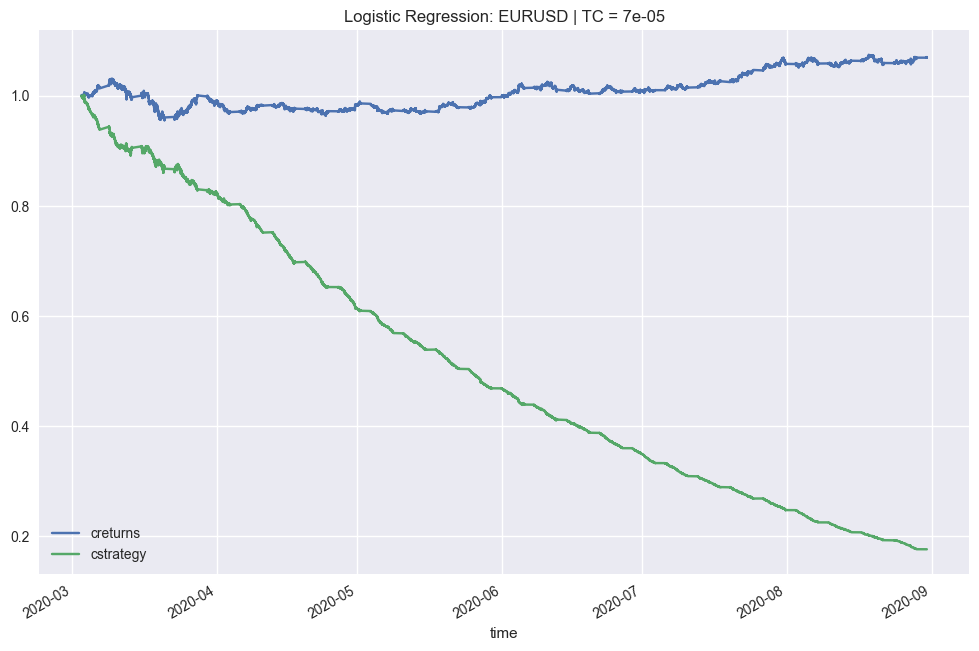

In [81]:
ml.plot_results()

In [82]:
ml.results

price   returns      lag1      lag2      lag3  \
time                                                                          
2020-03-03 00:20:00+00:00  1.113645 -0.000139 -0.000206 -0.000135 -0.000265   
2020-03-03 00:25:00+00:00  1.113745  0.000090 -0.000139 -0.000206 -0.000135   
2020-03-03 00:30:00+00:00  1.113755  0.000009  0.000090 -0.000139 -0.000206   
2020-03-03 00:35:00+00:00  1.113770  0.000013  0.000009  0.000090 -0.000139   
2020-03-03 00:40:00+00:00  1.113450 -0.000287  0.000013  0.000009  0.000090   
...                             ...       ...       ...       ...       ...   
2020-08-30 23:35:00+00:00  1.190895 -0.000080 -0.000092  0.000298  0.000046   
2020-08-30 23:40:00+00:00  1.191240  0.000290 -0.000080 -0.000092  0.000298   
2020-08-30 23:45:00+00:00  1.191515  0.000231  0.000290 -0.000080 -0.000092   
2020-08-30 23:50:00+00:00  1.191685  0.000143  0.000231  0.000290 -0.000080   
2020-08-30 23:55:00+00:00  1.191715  0.000025  0.000143  0.000231  0.000290   

                               lag4      lag5  pred  strategy  trades  \
time                                                                    
2020-03-03 00:20:00+00:00  0.000027  0.000058   1.0 -0.000139     0.0   
2020-03-03 00:25:00+00:00 -0.000265  0.000027   1.0  0.000090     0.0   
2020-03-03 00:30:00+00:00 -0.000135 -0.000265   1.0  0.000009     0.0   
2020-03-03 00:35:00+00:00 -0.000206 -0.000135   1.0  0.000013     0.0   
2020-03-03 00:40:00+00:00 -0.000139 -0.000206   1.0 -0.000287     0.0   
...                             ...       ...   ...       ...     ...   
2020-08-30 23:35:00+00:00  0.000000 -0.000151   1.0 -0.000220     2.0   
2020-08-30 23:40:00+00:00  0.000046  0.000000   1.0  0.000290     0.0   
2020-08-30 23:45:00+00:00  0.000298  0.000046  -1.0 -0.000371     2.0   
2020-08-30 23:50:00+00:00 -0.000092  0.000298  -1.0 -0.000143     0.0   
2020-08-30 23:55:00+00:00 -0.000080 -0.000092  -1.0 -0.000025     0.0   

                           creturns  cstrategy  
time                                            
2020-03-03 00:20:00+00:00  0.999861   0.999861  
2020-03-03 00:25:00+00:00  0.999951   0.999951  
2020-03-03 00:30:00+00:00  0.999960   0.999960  
2020-03-03 00:35:00+00:00  0.999973   0.999973  
2020-03-03 00:40:00+00:00  0.999686   0.999686  
...                             ...        ...  
2020-08-30 23:35:00+00:00  1.069218   0.176866  
2020-08-30 23:40:00+00:00  1.069528   0.176917  
2020-08-30 23:45:00+00:00  1.069775   0.176852  
2020-08-30 23:50:00+00:00  1.069927   0.176826  
2020-08-30 23:55:00+00:00  1.069954   0.176822  

[37001 rows x 12 columns]

__The optimal Number of Lags__

In [84]:
for lags in range(1, 21):
    print(lags, ml.test_strategy(train_ratio = 0.7, lags = lags))

1 (0.099865, -0.96947)
2 (0.155496, -0.91381)
3 (0.152651, -0.916938)
4 (0.166359, -0.903375)
5 (0.176822, -0.893132)
6 (0.182555, -0.887548)
7 (0.18158, -0.888427)
8 (0.182021, -0.887977)
9 (0.192528, -0.877455)
10 (0.185703, -0.884588)
11 (0.191589, -0.878793)
12 (0.187334, -0.883111)
13 (0.185525, -0.884953)
14 (0.180646, -0.89)
15 (0.180219, -0.890533)
16 (0.178193, -0.893131)
17 (0.177386, -0.894054)
18 (0.179068, -0.89191)
19 (0.180449, -0.890399)
20 (0.180706, -0.890205)


In [85]:
ml.results.trades.value_counts()

0.0    22711
2.0    14275
Name: trades, dtype: int64

### EURAUD

In [87]:
symbol = "EURAUD"
ml = MLBacktester(symbol, "2019-01-01", "2020-08-31", 0)

In [88]:
ml.test_strategy(train_ratio = 0.7, lags = 15)

(1.830543, 0.881757)

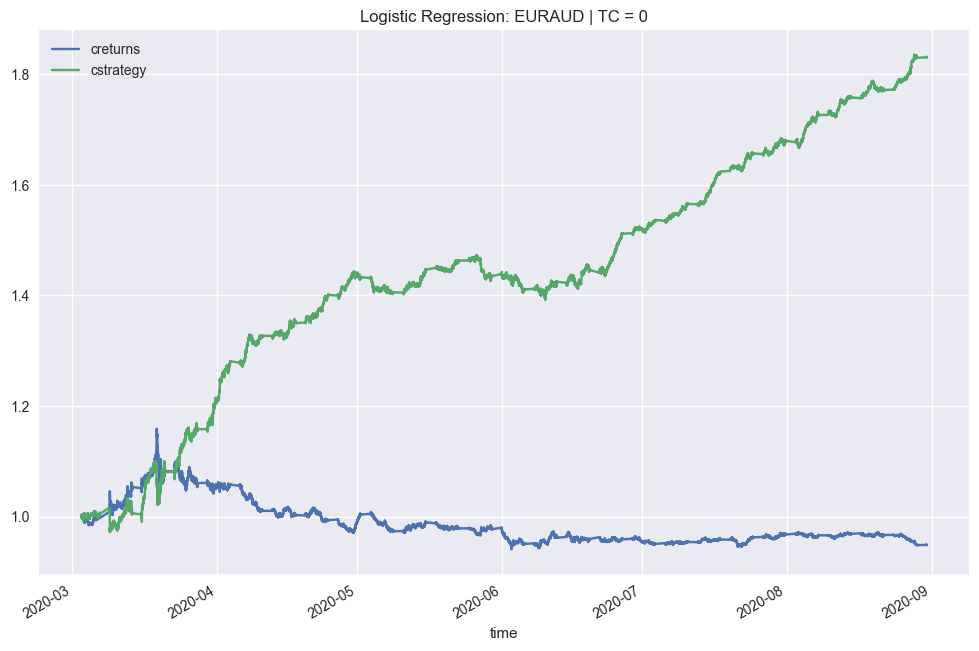

In [89]:
ml.plot_results()

__The optimal Number of Lags__

In [ ]:
for lags in range(1, 21):
    print(lags, ml.test_strategy(train_ratio = 0.7, lags = lags))

1 (1.618959, 0.669992)
2 (1.700957, 0.751976)
3 (1.688437, 0.738829)
